In [1]:
import torch
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, SequentialSampler

import matplotlib.pyplot as plt


import pickle
import os

import numpy as np
from sklearn.decomposition import PCA

import sys
sys.path.append("..")
from src.image_data import ImageClassificationDataset
from src.quantize import cluster_feat

### Download and View Data

In [2]:
root="/mnt/ssd/ronak/datasets/cifar10/"

In [3]:
train_data = CIFAR10(root, download=True)
test_data = CIFAR10(root, download=True, train=False)

x = train_data.data
y = np.array(train_data.targets)

print(x.shape)
print(y.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(50000,)


In [4]:
# x_train = np.tile(train_data.data[..., None], 3) / 255
x_train = train_data.data
y_train = np.array(train_data.targets)
# x_test =  np.tile(test_data.data[..., None], 3) / 255
x_test =  test_data.data
y_test = np.array(test_data.targets)

print(x_train[0, :, :, 0])
print(x_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))

np.save(os.path.join(root, "x_train.npy"), x_train)
np.save(os.path.join(root, "y_train.npy"), y_train)
np.save(os.path.join(root, "x_test.npy"), x_test)
np.save(os.path.join(root, "y_test.npy"), y_test)

[[ 59  43  50 ... 158 152 148]
 [ 16   0  18 ... 123 119 122]
 [ 25  16  49 ... 118 120 109]
 ...
 [208 201 198 ... 160  56  53]
 [180 173 186 ... 184  97  83]
 [177 168 179 ... 216 151 123]]
(50000, 32, 32, 3)
(50000,)
10


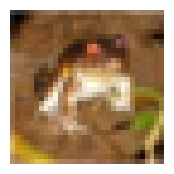

In [5]:
image = x[0]

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

### Load ConvNeXt Model

In [6]:
DATA_PATH = '/mnt/ssd/ronak/datasets/cifar10'
DEVICE = 'cuda:0'

In [7]:
model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1).to(DEVICE)
train_nodes, eval_nodes = get_graph_node_names(model)

/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [8]:
return_nodes = {
    # node_name: user-specified key for output dict
    'avgpool': 'features',
}
body = create_feature_extractor(model, return_nodes=return_nodes)

In [9]:
root = DATA_PATH

x_train = np.transpose(np.load(os.path.join(root, "x_train.npy")), axes=[0, 3, 1, 2])
y_train = np.load(os.path.join(root, "y_train.npy"))
print(x_train.shape)

batch_size = 256
transforms = ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms()
train_dataset = ImageClassificationDataset(x_train, y_train, transforms)
dataloader = DataLoader(
    train_dataset, sampler=SequentialSampler(train_dataset), batch_size=batch_size
)

(50000, 3, 32, 32)


In [10]:
all_image_features, all_labels, all_idx = [], [], []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader)):
        idx, images, labels = batch
        image_features = body(images.to(DEVICE))['features'].squeeze()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)
        all_labels.append(labels)
        all_idx.append(idx)
        
all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
all_labels = torch.cat(all_labels).cpu().detach().numpy()
all_idx = torch.cat(all_idx).cpu().detach().numpy()

0it [00:00, ?it/s]/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
196it [06:53,  2.11s/it]


In [12]:
torch.save(all_image_features, os.path.join(DATA_PATH, "convnext_base_features.pt"))
torch.save(all_labels, os.path.join(DATA_PATH, "convnext_base_labels.pt"))
torch.save(all_idx, os.path.join(DATA_PATH, "convnext_base_idx.pt"))

## Perform Quantization

In [13]:
NUM_CLUSTERS = 50
SEED = 11182023
DATASET = "cifar10"
DATA_PATH = f'/mnt/ssd/ronak/datasets/{DATASET}'

In [14]:
all_image_features = torch.load(os.path.join(DATA_PATH, "convnext_base_features.pt"))
all_labels = torch.load(os.path.join(DATA_PATH, "convnext_base_labels.pt"))
all_idx = torch.load(os.path.join(DATA_PATH, "convnext_base_idx.pt"))

In [15]:
image_labels, image_cluster = cluster_feat(all_image_features, NUM_CLUSTERS, seed=SEED)

label_to_idx = np.argsort(all_idx)
print(all_idx[label_to_idx])

# have the labels correspond to the indices in order.
image_labels_sorted = image_labels[label_to_idx]
class_labels_sorted = all_labels[label_to_idx]

print(image_labels_sorted.shape)
print(class_labels_sorted.shape)

[    0     1     2 ... 49997 49998 49999]
(50000,)
(50000,)


In [15]:
model_name = "convnext_base"
save_dir = f'/mnt/ssd/ronak/datasets/{DATASET}/quantization/{model_name}_kmeans_{NUM_CLUSTERS}'

os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f'image_labels.npy'), image_labels_sorted)
np.save(os.path.join(save_dir, f'class_labels.npy'), class_labels_sorted)

_, counts = np.unique(all_labels, return_counts=True)
y_marginal = counts/np.sum(counts)
x_marginal = image_cluster.marginal

np.save(os.path.join(save_dir, f'image_marginal.npy'), x_marginal)
np.save(os.path.join(save_dir, f'class_marginal.npy'), y_marginal)